<a href="https://colab.research.google.com/github/pratzz/Diabetes-Readmission-Prediction/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("../data/raw_data/diabetic_data.csv")
# data.head(10)

##### frequency_table: 
<br>check the frequence of classes in each category.
<br>May decide to drop/club the ones with low frequencies
<br>Or drop the category, if all the classes contribute relatovely uniform

In [3]:
def frequency_table(data, columns): 
    for column in columns:
        print("*"*50)
        print(pd.crosstab(index=data[column],  
                           columns="count").sort_values(by = "count", 
                                                        ascending = False))
        print("*"*50)
        
# columns = data.columns
# frequency_table(data, columns)
# frequency_table(data, ['readmitted'])

##### Feature Engineer 
race, gender, admission_type_id, discharge_disposition_id, admission_source_id, num_lab_procedures, 
num_medications, metformin, repaglinide, nateglinide, glimepiride, glipizide, glyburide, pioglitazone, 
rosiglitazone, acarbose,tolazamide,insulin,glyburide-metformin,glipizide-metformin,change, diabetesMed, readmitted
    
##### Dropping columns
<br> identifiers: encounter_id, patient_nbr
<br> High missing values: weight(97%), payer_code(40%), medical_specialty(50%)
<br> not administered to significant number of patients: acetohexamide, tolbutamide,examide, troglitazone, citoglipton, glimepiride-pioglitazone, glipizide-metformin, metformin- rosiglitazone, glyburide-metformin (not administered to significant number of patients)

In [4]:
drop_cols= ["encounter_id", "patient_nbr", "weight", 
            "payer_code", "medical_specialty", 
            "acetohexamide", "tolbutamide", "examide", 
            "troglitazone", "citoglipton", 
            "glimepiride-pioglitazone", "glipizide-metformin", 
            "metformin-rosiglitazone", "glyburide-metformin"]
data = data.drop(drop_cols, axis=1)

##### correlation_num_cols:
<br> to determine if strong correlations exists among features. 
<br> Features which are uncorrelated with the dependent variable are probably good candidates to trim from the model or perform feature engineering 
<br> If two features are strongly correlated to each other, then only one of them can be used

In [5]:
def correlation_num_cols():
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_cols = data.select_dtypes(include=numerics).columns
    return data.corr().style.background_gradient().set_precision(2)

correlation_num_cols()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
admission_type_id,1.00,0.08,0.11,-0.01,-0.14,0.13,0.08,0.03,-0.02,-0.04,-0.12
discharge_disposition_id,0.08,1.00,0.02,0.16,0.02,0.02,0.11,-0.01,-0.02,0.02,0.05
admission_source_id,0.11,0.02,1.00,-0.01,0.05,-0.14,-0.05,0.03,0.06,0.04,0.07
time_in_hospital,-0.01,0.16,-0.01,1.00,0.32,0.19,0.47,-0.01,-0.01,0.07,0.22
num_lab_procedures,-0.14,0.02,0.05,0.32,1.00,0.06,0.27,-0.01,-0.00,0.04,0.15
num_procedures,0.13,0.02,-0.14,0.19,0.06,1.00,0.39,-0.02,-0.04,-0.07,0.07
num_medications,0.08,0.11,-0.05,0.47,0.27,0.39,1.00,0.05,0.01,0.06,0.26
number_outpatient,0.03,-0.01,0.03,-0.01,-0.01,-0.02,0.05,1.00,0.09,0.11,0.09
number_emergency,-0.02,-0.02,0.06,-0.01,-0.00,-0.04,0.01,0.09,1.00,0.27,0.06
number_inpatient,-0.04,0.02,0.04,0.07,0.04,-0.07,0.06,0.11,0.27,1.00,0.10


##### col_split:
<br> feature engineered age column to keep the average instead of range

In [6]:
def col_split(df, col):
    df[col]=0.5*(df[col].str.partition('-')[0].astype(float)+
                    df[col].str.partition('-')[2].astype(float))
    return df

data["age"] = data["age"].map(lambda x: x.lstrip('[').rstrip(')'))
data = col_split(data, "age")

<AxesSubplot:ylabel='Density'>

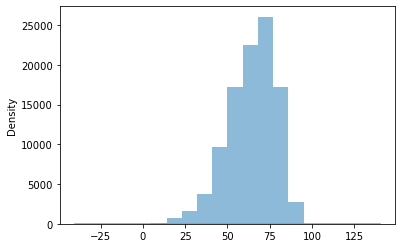

In [7]:
# check distribution
data["age"].plot.hist(alpha=0.5)
data["age"].plot.density()

In [8]:
data.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

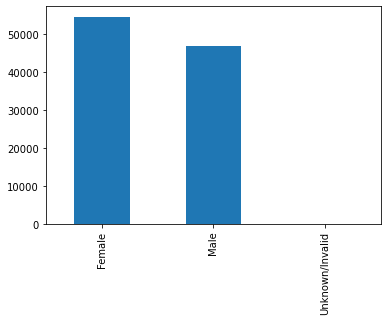

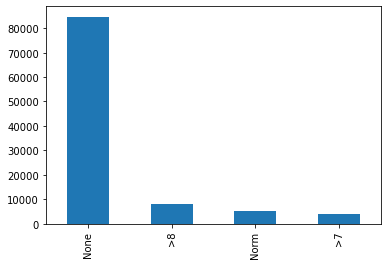

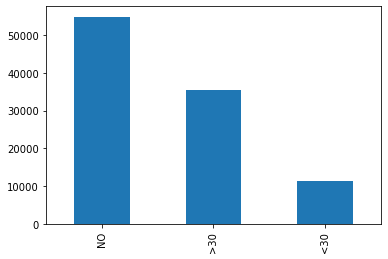

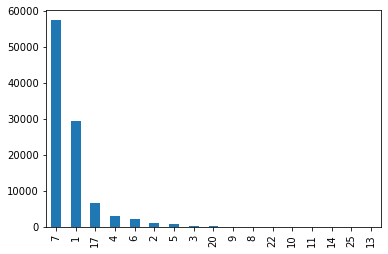

In [9]:
cols = ["gender", "A1Cresult", "readmitted", "admission_source_id"] 
def plot_categorical_bar():# for categorical var
    for col in cols:
        data[col].value_counts().plot(kind='bar')
        plt.show()
plot_categorical_bar()

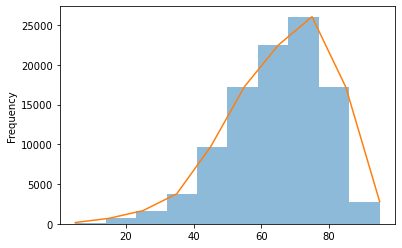

In [10]:
# import numpy
# import matplotlib.pyplot as plt

cols = ["age"] # for continuous var
def plot_density_bar():
    for col in cols:
        col_density = pd.crosstab(index = data[col],  
                    columns="count")
        data[col].plot.hist(alpha=0.5).plot(col_density)
        plt.show()
plot_density_bar()

#### drop_null:

drop rows with "?"

In [11]:
def drop_null(data, cols):
    for col in cols:
        data = data[data[col] != "?"]
    return data

cols = ["race", "diag_1", "diag_2", "diag_3"]
data = drop_null(data, cols)

In [12]:
def drop_row(col, values):
    df = data[~data[col].isin(values)]
    return df

# drop discharge_disposition_id - 3,4,5,7,8,10,11,13,14,16,17,18,19,20,21,22,23,24,25,26,28
values = [3,4,5,7,8,10,11,13,14,16,17,18,19,20,21,22,23,24,25,26,28]
data = drop_row("discharge_disposition_id",values)
data["discharge_disposition_id"].unique()

array([ 1,  6,  2, 12,  9, 15, 27], dtype=int64)

In [13]:
# frequency_table()

##### prob_table:
<br> to club/drop classes wrt probability of occurance in y

In [14]:
def prob_table(data, col, y):
    print("*"*50)
    print("feature/column:", col)
    temp_data = pd.crosstab(index=data[y], 
                             columns=data[col],
                             margins=True)   # Include row and column totals

    cols = sorted(data[col].unique())
    cols.append("rowtotal")
    temp_data.columns = cols
    temp_data.index= ["<30",">30","NO","coltotal"]

    print((temp_data/temp_data.loc["coltotal"]).round(2))
    print("*"*50)
    
columns = ["discharge_disposition_id","admission_source_id", "num_lab_procedures", "num_procedures",
 "max_glu_serum", "number_outpatient", "number_inpatient",
 "number_emergency", "number_diagnoses", "A1Cresult", "change"]
for col in columns:
    prob_table(data, col, "readmitted")

**************************************************
feature/column: discharge_disposition_id
             1     2     6     9    12    15   27  rowtotal
<30       0.09  0.16  0.13  0.43  0.67  0.44  0.0      0.10
>30       0.36  0.32  0.42  0.10  0.00  0.29  0.2      0.37
NO        0.54  0.52  0.45  0.48  0.33  0.27  0.8      0.53
coltotal  1.00  1.00  1.00  1.00  1.00  1.00  1.0      1.00
**************************************************
**************************************************
feature/column: admission_source_id
             1     2     3     4     5     6     7    8     9    10   11   13  \
<30       0.10  0.10  0.22  0.09  0.17  0.08  0.11  0.2  0.18  0.00  0.0  0.0   
>30       0.34  0.28  0.26  0.23  0.28  0.17  0.40  0.3  0.10  0.17  0.0  0.0   
NO        0.56  0.62  0.51  0.68  0.55  0.75  0.49  0.5  0.72  0.83  1.0  1.0   
coltotal  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.0  1.00  1.00  1.0  1.0   

           14    17    20    22   25  rowtotal  
<30       0.0  

In [15]:
data = data.drop("num_procedures", axis=1)

In [16]:
def create_features(data, info):
    for col, col_info in info.items():
        for name in col_info:
            values = col_info[name]
            data[col+name] = data[col].isin(values).astype(int)
        data = data.drop(col, axis=1)
    return data

In [17]:
# Encode these columns
info = {
    "admission_source_id": {">30": ["20"]},
    "num_lab_procedures": {"<30": ["132"], ">30": ["104", "129"]},
    "number_outpatient": {"<30":["23", "40"],
                          ">30":["6", "7", "10", "11", "12", "14", "15", "16", "18", "19", 
                                 "20", "21", "22", "23", "25", "26", "27", "28", "29", 
                                 "33", "34","35", "36", "37", "38", "39", "42"]},
    "number_inpatient": {"<30":["8", "9", "11", "12", "13", "15", "19", "21"],
                         ">30": ["2", "3", "4", "5", "6", "14","18"]},
    "number_emergency": {"<30": ["20", "21", "28", "64"],
                         ">30": ["2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12",
                                 "13", "14", "15", "18", "19", "21", "22", "24", "29", "42",
                                 "46", "54", "63", "76"]},
    "number_diagnoses": {">30":["11", "12"]},
    
    "discharge_disposition_id":{"1": ["1"]},
    "max_glu_serum": {"GS_MT200":[">200"],
                      "GS_MT300": [">300"],
                      "GS_NO": ["None"]},
    "A1Cresult": {"A1C_MT7": [">7"],
                  "A1C_MT8": [">8"],
                  "A1c_norm": ["Norm"]},
    "change": {"_encoded": ["Ch"]}
          }
data = create_features(data, info)

In [18]:
# convert to dummies
cat_cols = ["age", "race","gender","admission_type_id",
            "metformin","repaglinide","nateglinide",
            "chlorpropamide", "glimepiride", "glipizide",
            "glyburide", "pioglitazone", "rosiglitazone",
            "acarbose", "miglitol" , "tolazamide", "insulin",
           "diabetesMed", "metformin-pioglitazone"]

data = pd.get_dummies(data, columns=cat_cols)

##### ICD10 coding of diagnosis

In [19]:
import numpy as np
import string

circulatory_range = list(map(lambda n: '%g'%n, np.arange(390, 459, 0.1)))
circulatory_range.extend(["459","785"])
data.loc[data['diag_1'].isin(circulatory_range),"diag_1"] = "Circulatory"
data.loc[data['diag_2'].isin(circulatory_range),"diag_2"] = "Circulatory"
data.loc[data['diag_3'].isin(circulatory_range),"diag_3"] = "Circulatory"

respiratory_range = list(map(lambda n: '%g'%n, np.arange(460,519,0.1)))
respiratory_range.extend(["519", "786"])
data.loc[data['diag_1'].isin(respiratory_range),"diag_1"] = "Respiratory"
data.loc[data['diag_2'].isin(respiratory_range),"diag_2"] = "Respiratory"
data.loc[data['diag_3'].isin(respiratory_range),"diag_3"] = "Respiratory"

digestive_range = list(map(lambda n: '%g'%n, np.arange(520, 579, 0.1)))
digestive_range.extend(["579", "787"])
data.loc[data['diag_1'].isin(digestive_range),"diag_1"] = "Digestive"
data.loc[data['diag_2'].isin(digestive_range),"diag_2"] = "Digestive"
data.loc[data['diag_3'].isin(digestive_range),"diag_3"] = "Digestive"
                       
diabetes_range = list(map(lambda n: '%g'%n, np.arange(250,251, 0.01)))
diabetes_range.extend(["251","787"])
data.loc[data['diag_1'].isin(diabetes_range),"diag_1"] = "Diabetes"
data.loc[data['diag_2'].isin(diabetes_range),"diag_2"] = "Diabetes"
data.loc[data['diag_3'].isin(diabetes_range),"diag_3"] = "Diabetes"
                       
injury_range = list(map(lambda n: '%g'%n, np.arange(800, 999, 0.1)))
injury_range.append("999")
data.loc[data['diag_1'].isin(injury_range),"diag_1"] = "Injury"
data.loc[data['diag_2'].isin(injury_range),"diag_2"] = "Injury"
data.loc[data['diag_3'].isin(injury_range),"diag_3"] = "Injury"

musculoskeletal_range = list(map(lambda n: '%g'%n, np.arange(710, 739, 0.1)))
injury_range.append("739")
data.loc[data['diag_1'].isin(musculoskeletal_range),"diag_1"] = "Musculoskeletal"
data.loc[data['diag_2'].isin(musculoskeletal_range),"diag_2"] = "Musculoskeletal"
data.loc[data['diag_3'].isin(musculoskeletal_range),"diag_3"] = "Musculoskeletal"
                       
genito_urinary_range = list(map(lambda n: '%g'%n, np.arange(580, 629, 0.1)))
genito_urinary_range.extend(["629", "788"])
data.loc[data['diag_1'].isin(genito_urinary_range),"diag_1"] = "GenitoUrinary"
data.loc[data['diag_2'].isin(genito_urinary_range),"diag_2"] = "GenitoUrinary"
data.loc[data['diag_3'].isin(genito_urinary_range),"diag_3"] = "GenitoUrinary"

neoplasms_range = list(map(lambda n: '%g'%n, np.arange(1, 239, 0.1)))
neoplasms_range.extend(list(map(lambda n: '%g'%n, np.arange(790, 799, 0.1))))
neoplasms_range.extend(list(map(lambda n: '%g'%n, np.arange(240, 249, 0.1))))
neoplasms_range.extend(list(map(lambda n: '%g'%n, np.arange(251, 279, 0.1))))
neoplasms_range.extend(list(map(lambda n: '%g'%n, np.arange(680, 709, 0.1))))
neoplasms_range.extend(["239", "799", "249", "279", "709", "780", "781", "784", "782"])
data.loc[data['diag_1'].isin(neoplasms_range),"diag_1"] = "Neoplasms"
data.loc[data['diag_2'].isin(neoplasms_range),"diag_2"] = "Neoplasms"
data.loc[data['diag_3'].isin(neoplasms_range),"diag_3"] = "Neoplasms"
                       
others_range = list(map(lambda n: '%g'%n, np.arange(280, 389, 0.01)))
others_range.extend(list(map(lambda n: '%g'%n, np.arange(630, 679, 0.1))))
others_range.extend(list(map(lambda n: '%g'%n, np.arange(740, 759, 0.1))))
others_range.extend(["389", "679", "759", "783", "789", "E909"])

data.loc[data['diag_1'].isin(others_range),"diag_1"] = "Others"
data.loc[data['diag_2'].isin(others_range),"diag_2"] = "Others"
data.loc[data['diag_3'].isin(others_range),"diag_3"] = "Others"

data.loc[data['diag_1'].str.match('^[E-V][0-9]*$'), "diag_1"] = "Others"
data.loc[data['diag_2'].str.match('^[E-V][0-9]*$'), "diag_2"] = "Others"
data.loc[data['diag_3'].str.match('^[E-V][0-9]*$'), "diag_3"] = "Others"

In [20]:
data["diag_1"].unique()

array(['Neoplasms', 'Others', 'Circulatory', 'Diabetes', 'Respiratory',
       'Injury', 'GenitoUrinary', 'Digestive', 'Musculoskeletal'],
      dtype=object)

In [21]:
data["diag_2"].unique()

array(['Diabetes', 'Neoplasms', 'Circulatory', 'Respiratory', 'Others',
       'Injury', 'Musculoskeletal', 'GenitoUrinary', 'Digestive'],
      dtype=object)

In [22]:
data["diag_3"].unique()

array(['Neoplasms', 'Others', 'Circulatory', 'Diabetes', 'Injury',
       'GenitoUrinary', 'Respiratory', 'Digestive', 'Musculoskeletal'],
      dtype=object)

In [23]:
from category_encoders.hashing import HashingEncoder

X = pd.DataFrame(data, columns=data.columns)
y = data.readmitted
he = HashingEncoder(cols=['diag_1', 'diag_2', 'diag_3'], n_components = 3).fit(X, y)
data = he.transform(X)

# data.info()
# data.head()


C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [24]:
# data["readmitted"].value_counts()
data["readmitted"]=np.where(data["readmitted"]=="NO", 1, 0)
# data["readmitted"].value_counts()

In [25]:
X = data
y = data["readmitted"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
x_val, x_test,  y_val,  y_test = train_test_split(x_test, y_test, test_size=0.3, random_state=42, stratify=y_test)

In [26]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=5)
# x_train = pca.fit_transform(x_train)
# x_test = pca.transform(x_test)
# x_val = pca.transform(x_val)

# np.save("../data/processed_data/x_train.npy", x_train)
# np.save("../data/processed_data/x_test.npy", x_test)
# np.save("../data/processed_data/x_val.npy", x_val)
# np.save("../data/processed_data/y_train.npy", y_train)
# np.save("../data/processed_data/y_test.npy", y_test)
# np.save("../data/processed_data/y_val.npy", y_val)

In [27]:
x_train.to_csv('../data/processed_data/x_train.csv',index=False)
x_val.to_csv('../data/processed_data/x_val.csv',index=False)
y_train.to_csv('../data/processed_data/y_train.csv',index=False)
y_val.to_csv('../data/processed_data/y_val.csv',index=False)
x_test.to_csv('../data/processed_data/x_test.csv',index=False)
y_test.to_csv('../data/processed_data/y_test.csv',index=False)